[Link to the task description in Notion](https://www.notion.so/coding-bootcamps/A-test-assignment-for-a-growth-analyst-Latam-May-2025-1ed6ed1efc9380b8a6bdc1f315e52b7f)

# Task 1. Predictive modelling Evaluation

**Task Description:** You need to evaluate a lead scoring model for TripleTen.

The scoring system is based on a questionnaire, which appears early in the acquisition funnel and allows the team to segment the audience into categories. You can find the questionnaire, for example, on this landing page as a built-in frame https://tripleten.mx/#subscribe, or use a [direct](https://form.typeform.com/to/xWGnAgpf) link to it.

A fellow analyst has prepared for you an overview of the segments and made a crayon note on it.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import shapiro, norm, ttest_ind, mannwhitneyu, stats

In [2]:
# Обновлённые данные сразу с долями
data = {
    "Score": [-4, -3, -2, -1, 0, 1, 2, 3, 4],
    "% of Total Deals": [0.01, 0.04, 0.19, 0.29, 0.22, 0.15, 0.08, 0.01, 0.0],
    "% of Total Meeting Attended": [0.0, 0.0, 0.01, 0.25, 0.33, 0.26, 0.12, 0.02, 0.0],
    "% of Total Payment": [0.0, 0.0, 0.01, 0.13, 0.33, 0.38, 0.13, 0.02, 0.0],
    "Segment": ["0_low", "0_low", "0_low", "0_low", "1_medium", "2_high", "2_high", "2_high", "2_high"],
    "CR Segment (Deal-Payment)": [0.018, 0.018, 0.018, 0.018, 0.105, 0.146, 0.146, 0.146, 0.146]
}

df = pd.DataFrame(data)
df

,Score,% of Total Deals,% of Total Meeting Attended,% of Total Payment,Segment,CR Segment (Deal-Payment)
0,-4,0.01,0.00,0.00,0_low,0.018
1,-3,0.04,0.00,0.00,0_low,0.018
2,-2,0.19,0.01,0.01,0_low,0.018
3,-1,0.29,0.25,0.13,0_low,0.018
4,0,0.22,0.33,0.33,1_medium,0.105
5,1,0.15,0.26,0.38,2_high,0.146
6,2,0.08,0.12,0.13,2_high,0.146
7,3,0.01,0.02,0.02,2_high,0.146
8,4,0.00,0.00,0.00,2_high,0.146


**How to read the table**
- Each answer for each question has its own weight (can be negative) and after completion weights are summarized (linearly), and results in a score in range of [-4,4].
- In the table you can find scoring results (points), and a respective share of CRM deals (a deal is created after the scoring is completed and a person books a call with a salesperson), attended meeting with salespeople (MA, you can assume it is proportional to sales department capacity = how many calls they can reasonably conduct within the period), payments and overall CR(deal-payment). E.g. a group of leads, who scored 1 point in the survey, represents 15% of all our deals in September 2024, attended 26% of all meetings in the same cohort, and resulted in 38% of all cohort purchases (all purchases made in any month resulted from deals created in September 2024)
- The TripleTen growth team currently groups all segments into 3 categories: low, medium, high
- The screenshot should be sufficient to answer questions, but if you want to, feel free to explore the [spreadsheet](https://docs.google.com/spreadsheets/d/13KFUBlcCzOC7-hWm5QHvSyQUtXwGXLpTZUC3DlOWOT4/edit?usp=sharing).

**Assumptions about sales efforts**
- There is only one sales script. You can assume that salespeople don’t see the segment or the scoring; they get “a next call” from an automated system.
- The call with a salesperson is the only option to purchase our product. For this task, you can assume there’s no auto-funnels or the demo versions of the courses.
- You can assume that all purchases had the same price. This is a huge simplification, but the pricing policy is out of scope for this task.
- In the context of this task, don’t consider long-term effects like retention and referrals.
- For this particular funnel, you can assume that we sell only reskilling courses, thus, each student will purchase our courses only once in their lifetime.

**Your task is to assess the model and answer the following questions:**
1. Is the model “good enough” for its current application? Describe a criteria for the growth team to stop/continue using the model. **(We are looking for a simple critera, easily explainable to the team. If you decide to go for a composite metric, please limit it to 2-3 components)**
2. Provide a ranked list of 3-4 hypothesis for how the growth team can boost acquisition of prospective students by utilizing this model in other ways (or by improving the existing model). **Please, focus on a clear description of business impact of hypothesis, not on statistically accurate wording.**

## Question 1: Is the model “good enough” for its current application?

### Step 1: Understand what “good enough” means here

In [3]:
# group rows by segment
df_overview_segment = df.groupby('Segment').agg({
    '% of Total Deals': 'sum',
    '% of Total Meeting Attended': 'sum',
    '% of Total Payment': 'sum'
}).reset_index()

df_overview_segment['cr'] = [0.018, 0.105, 0.146]

df_overview_segment


,Segment,% of Total Deals,% of Total Meeting Attended,% of Total Payment,cr
0,0_low,0.53,0.26,0.14,0.018
1,1_medium,0.22,0.33,0.33,0.105
2,2_high,0.24,0.40,0.53,0.146


In [4]:
# group rows by score
df_overview_score = df.groupby('Score').agg({
    '% of Total Deals': 'sum',
    '% of Total Meeting Attended': 'sum',
    '% of Total Payment': 'sum'
}).reset_index()

df_overview_score

,Score,% of Total Deals,% of Total Meeting Attended,% of Total Payment
0,-4,0.01,0.00,0.00
1,-3,0.04,0.00,0.00
2,-2,0.19,0.01,0.01
3,-1,0.29,0.25,0.13
4,0,0.22,0.33,0.33
5,1,0.15,0.26,0.38
6,2,0.08,0.12,0.13
7,3,0.01,0.02,0.02
8,4,0.00,0.00,0.00


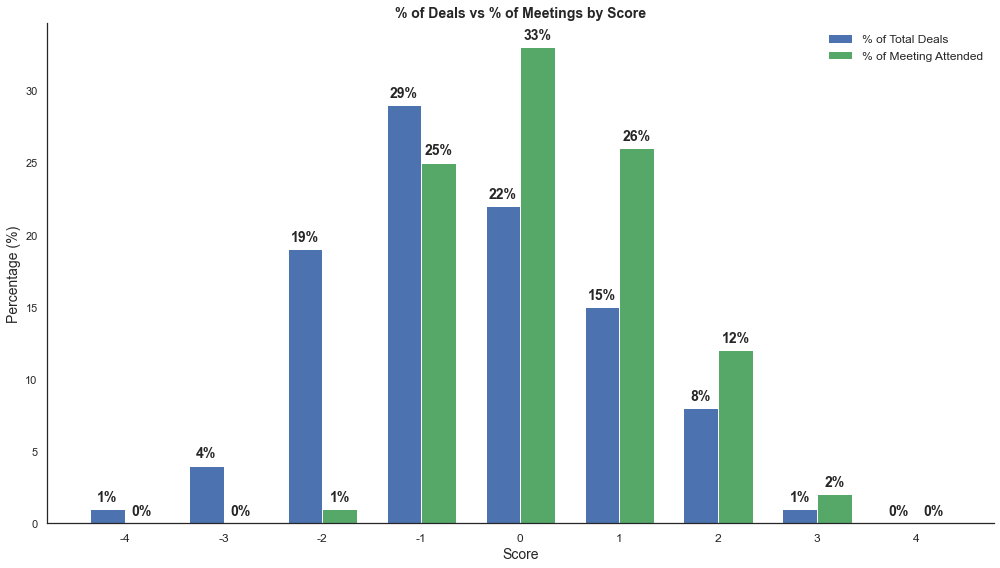

In [5]:
# Visualisation metrics by score
sns.set(style="white")

# Prepare data (multiply by 100 and round for better visualization)
scores = df_overview_score['Score']
deals = (df_overview_score['% of Total Deals'] * 100).round()
meetings = (df_overview_score['% of Total Meeting Attended'] * 100).round()

x = range(len(scores))
width = 0.35
colors = ['#4C72B0', '#55A868']

# Plotting the chart
fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar([i - width/2 for i in x], deals, width, label='% of Total Deals', color=colors[0])
bars2 = ax.bar([i + width/2 for i in x], meetings, width, label='% of Meeting Attended', color=colors[1])

# Axis labels and title
ax.set_xlabel('Score', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_title('% of Deals vs % of Meetings by Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scores, fontsize=12)
ax.legend(frameon=False, fontsize=12)

# Add data labels above bars (as integers, no decimal places)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=14, fontweight='bold')

# Final formatting
sns.despine()
plt.tight_layout()
plt.show()


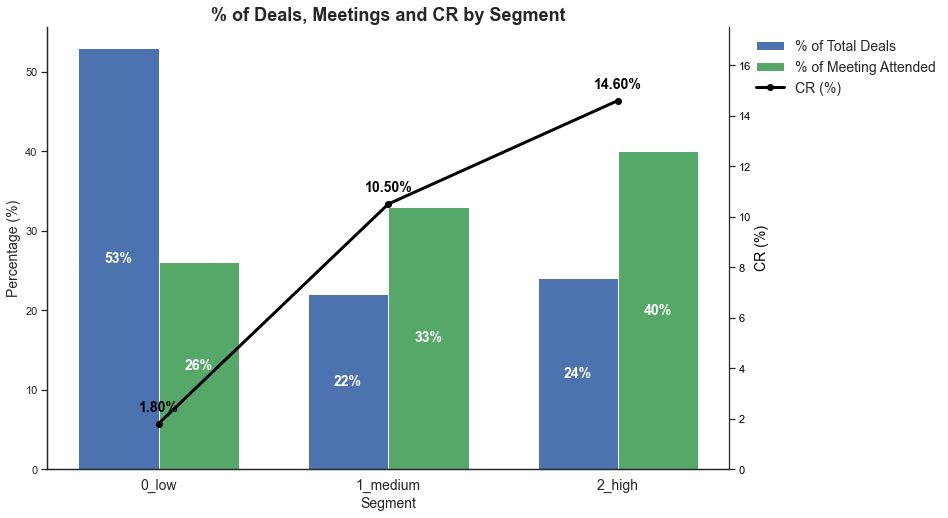

In [6]:
# Visualize metrics by segment
sns.set(style="white")

segments = df_overview_segment['Segment']
deals = (df_overview_segment['% of Total Deals'] * 100).round()
meetings = (df_overview_segment['% of Total Meeting Attended'] * 100).round()
cr = df_overview_segment['cr'] * 100  # expressed in percentage

x = np.arange(len(segments))
width = 0.35
colors = ['#4C72B0', '#55A868']

fig, ax = plt.subplots(figsize=(14, 8))  # larger figure size

bars1 = ax.bar(x - width/2, deals, width, label='% of Total Deals', color=colors[0])
bars2 = ax.bar(x + width/2, meetings, width, label='% of Meeting Attended', color=colors[1])

# Axis labels and title
ax.set_xlabel('Segment', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_title('% of Deals, Meetings and CR by Segment', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=14)

# Add data labels inside bars (in white for contrast)
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}%',
                xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                xytext=(0, 0),
                textcoords="offset points",
                ha='center', va='center',
                fontsize=14, fontweight='bold', color='white')

# Add secondary y-axis for Conversion Rate (CR)
ax2 = ax.twinx()
line_cr, = ax2.plot(x, cr.values, color='black', linewidth=3, marker='o', label='CR (%)')  # black line for CR
ax2.set_ylabel('CR (%)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, max(cr.values) * 1.2)

# Add CR values above the line
for i, val in enumerate(cr.values):
    ax2.annotate(f'{val:.2f}%',
                 xy=(x[i], val),
                 xytext=(0, 12),
                 textcoords='offset points',
                 ha='center',
                 color='black',
                 fontsize=14,
                 fontweight='bold')

# Combine legends from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Display legend outside the top-right of the main plot area
ax.legend(all_handles, all_labels, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, fontsize=14)

sns.despine(ax=ax)
sns.despine(ax=ax2, right=False)

plt.tight_layout(pad=3)
plt.show()


### Step 2: Overview key model metrics from the table

1) Low segment (score ≤ -1):
~53% of deals but only 14% of payments → very low conversion (1.8% CR).

2) Medium segment (score = 0):
22% of deals, 33% payments, CR = 10.5% → better conversion.

3) High segment (score ≥ 1):
24% deals, 53% payments, CR = 14.6% → best conversion.

### Step 3: Interpretation

1) The model clearly segments leads by quality:
- Low segment has very low conversion rate.
- Medium segment is better.
- High segment is significantly better than low and medium.

2) The sales efforts seem to be distributed (meetings %), but high segment has disproportionately more payments despite fewer deals.
3) The conversion rate (CR) difference is the main success indicator here.

### Step 4: Define a simple criterion for the growth team

**Criterion 1: Meeting Allocation Efficiency**

The model is good enough if the High + Medium segments have:
- ✅ At least 70% of Total Meetings  
- ✅ At least 70% of Total Payments

**Why it matters:**  
This ensures that the sales team spends most of their time on leads that actually generate revenue, making the sales process more efficient and reducing wasted effort on low-potential leads.

**Result:**  
- 73% of Meetings  
- 86% of Payments  
- ✅ Pass

---

**Criterion 2: Conversion Rate Separation**

The model is good enough if:
- ✅ High segment conversion rate is at least 5× the Low segment  
- ✅ Medium segment conversion rate is between Low and High

**Why it matters:**  
This confirms the model meaningfully distinguishes between lead quality levels, so the scoring is predictive of actual buying behavior and can be trusted to guide sales prioritization.

**Result:**  
- Low CR = 1.8%  
- Medium CR = 10.5%  
- High CR = 14.6% (~8× Low)  
- ✅ Pass

---

**Conclusion:**  
The model meets both criteria and is good enough to continue using. It helps focus sales efforts and predicts lead quality well.


## Question 2: What are the top 3 ranked hypothesis for how the growth team can boost acquisition of prospective students by utilizing this model in other ways

### H1. Prioritize Sales Effort on High and Medium Segments to Maximize Conversion
**Why:**  High and Medium segments represent 63% of meetings but 86% of payments (40% + 33%), showing they convert much better than Low. Focusing sales effort here makes the best use of limited sales capacity.

**Hypothesis:** If sales efforts (calls/meetings) are reallocated to focus more on leads in the High and Medium segments, overall conversion and revenue will increase without needing more sales resources.

**Action:** Use the scoring model to automatically prioritize scheduling calls for leads in the High and Medium segments earlier and more frequently, before Low segment leads. **Note:** Once this segmentation-based prioritization shows consistent results, consider refining further by using the exact lead score within each segment to prioritize the highest-scoring leads first, for even better efficiency.

### H2. Design Tailored Messaging or Nurturing for Low Segment Leads to Increase Their Quality

**Why:**  Low segment leads represent 53% of deals but only 14% of payments and have a very low conversion rate (1.8%).

**Hypothesis:** If low-scoring leads receive targeted nurturing or educational content that helps qualify them better or encourages behaviors closer to Medium/High segments, their conversion rate will improve.

**Action:** Create automated email campaigns or pre-sales content specifically tailored for low segment leads to engage and nurture them before they are passed to sales.

### H3. Create Separate Sales Tracks or Offers Based on Segment

**Why:** The conversion rate difference between segments is large (Low = 1.8%, Medium = 10.5%, High = 14.6%).

**Hypothesis:** If sales and marketing messaging, offers, or pricing are customized by segment (e.g., higher-touch sales for High, self-service or trial offers for Low), overall funnel efficiency and conversion will improve.

**Action:** Experiment with segment-specific sales scripts, offers, or funnel flows to better match lead readiness and willingness to buy.

# Task 2. A rather technical A/B test

### Step 1. Review Task Description

**Task Description:** Imagine that, together with the growth and marketing departments, you conducted an experiment with an expectation of revenue increase.

- Variant A: Payment screen without any promotional offers
- Variant B: Payment screen with the promotional offer "You might also like these"

You conducted an A/B test and obtained results described in the files orders.csv and visitors.csv.

File `orders.csv`. [Download dataset](https://drive.google.com/file/d/1nEETqWR9zFlGv7zmMrwmqI2fNgENQO-Z/view?usp=sharing)

- `transactionId` — order identifier;
- `visitorId` — user identifier who made the order;
- `date` — date when the order was placed;
- `revenue` — order revenue;
- `group` — A/B test group the order belongs to.

File `visitors.csv`. [Download dataset](https://drive.google.com/file/d/1D8H4-g-nknV1H-DEjSy1RAYuvfLNEWs3/view?usp=sharing)

- `date` — date;
- `group` — A/B test group;
- `visitors` — number of users on the specified date in the specified A/B test group

**Your task is evaluate the results of the A/B test, formulate a conclusion, and provide recommendations for the growth department.**

### Step 2. Understand the Goal

Define the key metrics that will be used to measure success:
- **Conversion Rate** - How many visitors made a purchase 
- **Average Order Value (AOV)** - How much revenue was made per order   
- **ARPU (Revenue per Visitor)** - The ultimate performance metric (revenue efficiency)

### Step 3: Preprocessing

#### Table Orders

In [7]:
# upload data
orders = pd.read_csv('test_orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
# overview data
orders.shape

(1197, 5)

In [9]:
# overview data
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
# rename columns according to snake_case and adjust types

orders.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id'
}, inplace=True)

orders['date'] = pd.to_datetime(orders['date'])


In [11]:
# overview min & max date
orders['date'].min(),orders['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

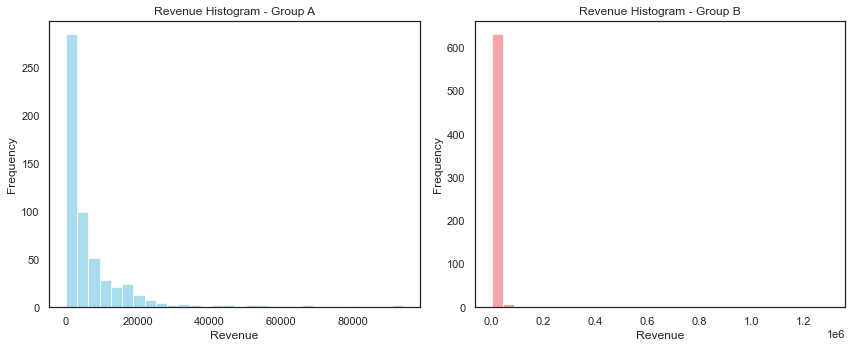

In [12]:
# Overview revenue distribution 
# Define group colors
group_colors = {'A': 'skyblue', 'B': 'lightcoral'}

# Ensure the order is A then B
groups = sorted(orders['group'].unique())

plt.figure(figsize=(12, 5))

for i, group in enumerate(groups, 1):
    plt.subplot(1, len(groups), i)
    group_data = orders.loc[orders['group'] == group, 'revenue']
    plt.hist(group_data, bins=30, alpha=0.7, color=group_colors.get(group, 'gray'))
    plt.title(f'Revenue Histogram - Group {group}')
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


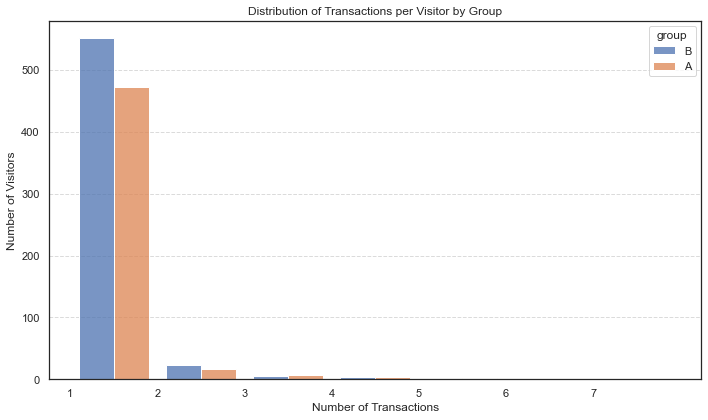

In [13]:
# Count the number of transactions per visitor
transactions_per_visitor = orders.groupby(['visitor_id', 'group'])['transaction_id'].count().reset_index()
transactions_per_visitor = transactions_per_visitor.rename(columns={'transaction_id': 'transactions'})

# Plot histogram split by groups
plt.figure(figsize=(10, 6))

# Histogram for each group
sns.histplot(data=transactions_per_visitor, 
             x='transactions', 
             bins=range(1, transactions_per_visitor['transactions'].max() + 2),
             hue='group', 
             multiple='dodge', 
             shrink=0.8, 
             kde=False)

plt.title('Distribution of Transactions per Visitor by Group')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Visitors')
plt.xticks(range(1, transactions_per_visitor['transactions'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
# Count visitors' intersection in both groups

# Total number of unique visitors
total_visitors = orders['visitor_id'].nunique()

# Number of visitors who appeared in multiple groups
visitor_groups = orders.groupby('visitor_id')['group'].nunique().reset_index()
visitors_in_multiple_groups = visitor_groups[visitor_groups['group'] > 1]

print(f"Total number of unique visitors: {total_visitors}")
print(f"Number of visitors who appeared in both groups: {len(visitors_in_multiple_groups)}")


Total number of unique visitors: 1031
Number of visitors who appeared in both groups: 58


**Issue 1: Presence of outliers in the control group**  
We have detected unusually high values in the control group’s data that may skew analysis results.

**Issue 2: Overlap between test and control groups**  
Some users appear in both the test and control groups, which can bias the A/B test outcomes.

---

**Proposed solutions:**

- **For Issue 2 (Overlap):**  
  Identify users who appear in both groups (intersected users) and remove them from the dataset to ensure mutually exclusive groups.

- **For Issue 1 (Outliers):**  
  Calculate key percentiles (e.g., 95th and 99th) to understand the distribution of values. Then decide on a threshold to filter or cap outlier values in the control group for cleaner analysis.


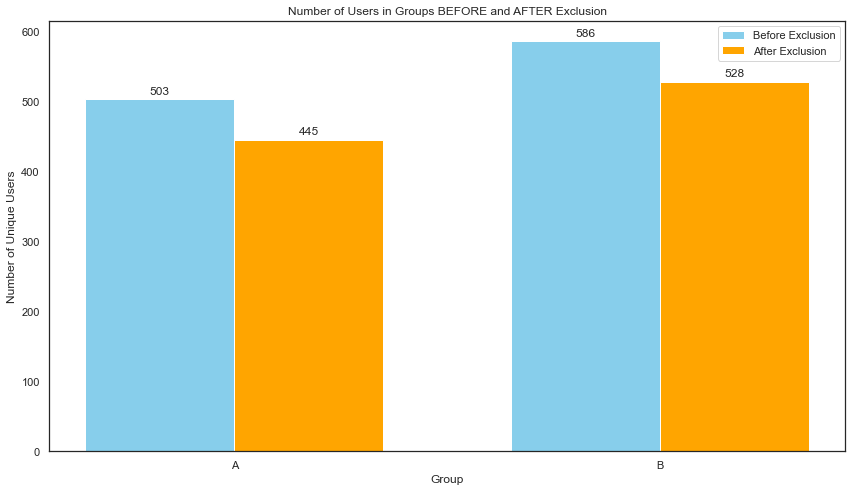

In [15]:
# Number of unique users in each group BEFORE exclusion
users_before = orders.groupby('group')['visitor_id'].nunique()

# Users who appeared in both groups
visitor_groups = orders.groupby('visitor_id')['group'].nunique().reset_index()
visitors_in_both_groups = visitor_groups[visitor_groups['group'] > 1]['visitor_id']

# Exclude these users — create a new dataframe without them
orders_no_intersection = orders[~orders['visitor_id'].isin(visitors_in_both_groups)]

# Number of unique users AFTER exclusion
users_after = orders_no_intersection.groupby('group')['visitor_id'].nunique()

groups = users_before.index.tolist()
x = np.arange(len(groups))

width = 0.35

fig, ax = plt.subplots(figsize=(12,7))

bars1 = ax.bar(x - width/2, users_before, width, label='Before Exclusion', color='skyblue')
bars2 = ax.bar(x + width/2, users_after, width, label='After Exclusion', color='orange')

ax.set_xlabel('Group')
ax.set_ylabel('Number of Unique Users')
ax.set_title('Number of Users in Groups BEFORE and AFTER Exclusion')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

# Labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [16]:
# Find outliers and its count
# Percentiles of interest
percentiles = [0.9, 0.95, 0.99, 0.999, 0.9999]

# Groups to analyze
groups = ['A', 'B']

# Calculation and output
for group in groups:
    group_data = orders_no_intersection[orders_no_intersection['group'] == group]['revenue']
    print(f"\nPercentiles and number of outliers for group {group}:")
    for p in percentiles:
        threshold = group_data.quantile(p)
        outliers_count = (group_data > threshold).sum()
        print(f"{p:.4f} percentile: {threshold:,.2f} — outliers above threshold: {outliers_count}")



Percentiles and number of outliers for group A:
0.9000 percentile: 17,990.00 — outliers above threshold: 46
0.9500 percentile: 24,944.50 — outliers above threshold: 24
0.9900 percentile: 56,064.18 — outliers above threshold: 5
0.9990 percentile: 81,080.48 — outliers above threshold: 1
0.9999 percentile: 91,403.05 — outliers above threshold: 1

Percentiles and number of outliers for group B:
0.9000 percentile: 17,990.00 — outliers above threshold: 53
0.9500 percentile: 27,561.50 — outliers above threshold: 28
0.9900 percentile: 49,553.60 — outliers above threshold: 6
0.9990 percentile: 697,307.28 — outliers above threshold: 1
0.9999 percentile: 1,234,780.73 — outliers above threshold: 1


In [17]:
# Remove outliers by applying the 0.99 percentile threshold
threshold = orders_no_intersection['revenue'].quantile(0.99)
filtered_orders = orders_no_intersection[orders_no_intersection['revenue'] <= threshold]

In [18]:
# Distribution after removing outliers
# Percentiles of interest
percentiles = [0.9, 0.95, 0.99, 0.999, 0.9999]

# Groups to analyze
groups = ['A', 'B']

# Calculation and output
for group in groups:
    group_data = filtered_orders[filtered_orders['group'] == group]['revenue']
    print(f"\nPercentiles and number of outliers for group {group}:")
    for p in percentiles:
        threshold = group_data.quantile(p)
        outliers_count = (group_data > threshold).sum()
        print(f"{p:.4f} percentile: {threshold:,.2f} — outliers above threshold: {outliers_count}")



Percentiles and number of outliers for group A:
0.9000 percentile: 17,564.40 — outliers above threshold: 47
0.9500 percentile: 22,710.50 — outliers above threshold: 24
0.9900 percentile: 47,253.70 — outliers above threshold: 5
0.9990 percentile: 53,904.00 — outliers above threshold: 0
0.9999 percentile: 53,904.00 — outliers above threshold: 0

Percentiles and number of outliers for group B:
0.9000 percentile: 17,749.40 — outliers above threshold: 55
0.9500 percentile: 25,875.00 — outliers above threshold: 28
0.9900 percentile: 38,923.80 — outliers above threshold: 6
0.9990 percentile: 53,358.83 — outliers above threshold: 1
0.9999 percentile: 53,849.48 — outliers above threshold: 1


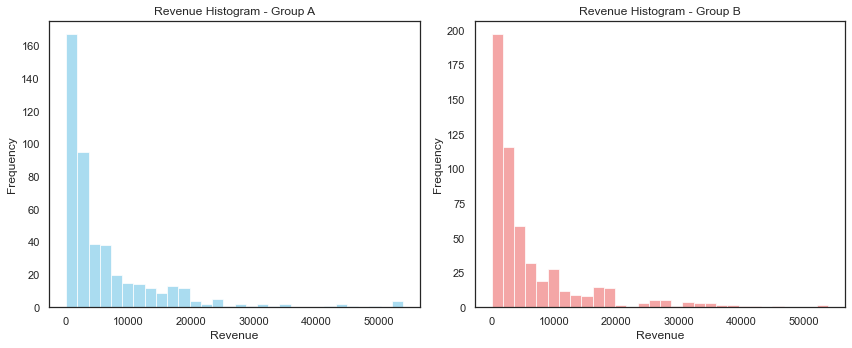

In [19]:
# Updated Plot
# Define group colors
group_colors = {'A': 'skyblue', 'B': 'lightcoral'}

# Ensure the order is A then B
groups = sorted(filtered_orders['group'].unique())

plt.figure(figsize=(12, 5))

for i, group in enumerate(groups, 1):
    plt.subplot(1, len(groups), i)
    group_data = filtered_orders.loc[filtered_orders['group'] == group, 'revenue']
    plt.hist(group_data, bins=30, alpha=0.7, color=group_colors.get(group, 'gray'))
    plt.title(f'Revenue Histogram - Group {group}')
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

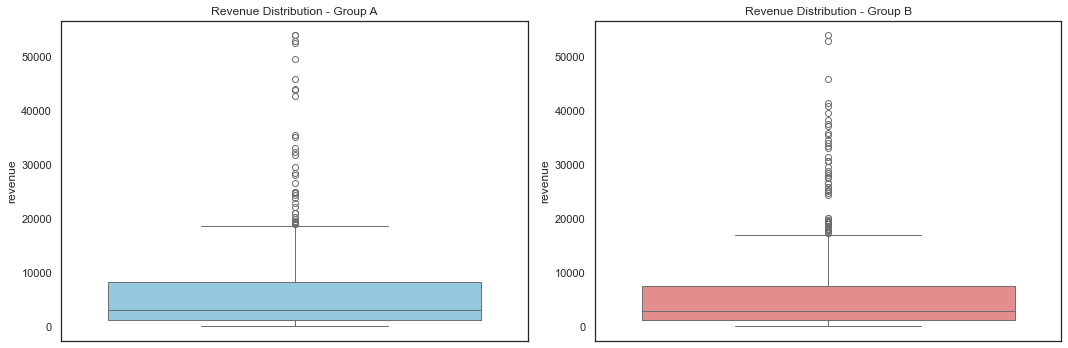

In [20]:
# make box blot
# Split groups
group_a = filtered_orders[filtered_orders['group'] == 'A']
group_b = filtered_orders[filtered_orders['group'] == 'B']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Group A - blue
sns.boxplot(data=group_a, y='revenue', ax=axes[0], color='skyblue')
axes[0].set_title('Revenue Distribution - Group A')

# Group B - red
sns.boxplot(data=group_b, y='revenue', ax=axes[1], color='lightcoral')
axes[1].set_title('Revenue Distribution - Group B')

# Improve layout
plt.tight_layout()
plt.show()


#### Table Visitors

In [21]:
# overview data
visitors = pd.read_csv('test_visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [22]:
# overview data
visitors.shape

(62, 3)

In [23]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [24]:
# adjust types
visitors['date'] = pd.to_datetime(visitors['date'])

In [25]:
# overview dates
visitors['date'].min(),visitors['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

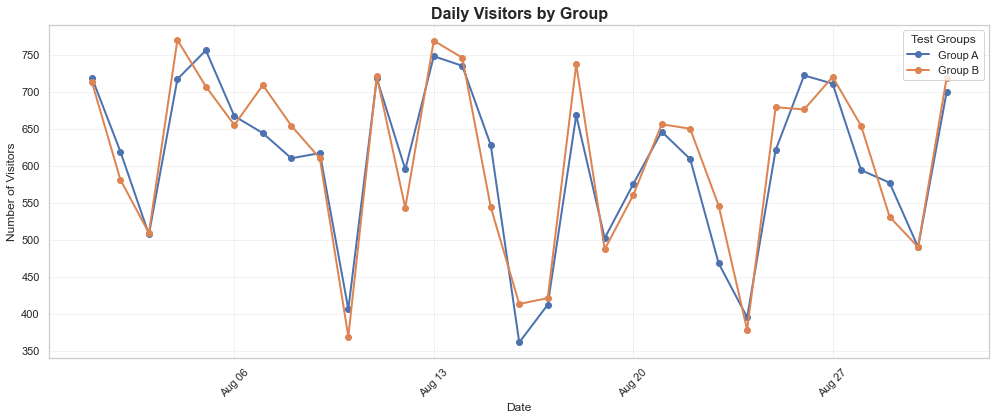

In [26]:
# overview distribution by visitors
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

for group in visitors['group'].unique():
    grp_data = visitors[visitors['group'] == group]
    plt.plot(
        grp_data['date'].values, 
        grp_data['visitors'].values, 
        marker='o', 
        label=f'Group {group}', 
        linewidth=2
    )

plt.title('Daily Visitors by Group', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Visitors', fontsize=12)
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.legend(title='Test Groups', loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


**Visitors Data seems quite nornal**

#### Joined Table

In [27]:
# aggregate orders on date and group
orders_daily = (
    filtered_orders.groupby(['date', 'group'])
    .agg(customers_count=('visitor_id', 'nunique'),
        orders_count=('transaction_id', 'nunique'),
         revenue_sum=('revenue', 'sum'))
    .reset_index()
)

# merge table
merged_df = pd.merge(visitors, orders_daily, how='left', on=['date', 'group'])
merged_df.head()

,date,group,visitors,customers_count,orders_count,revenue_sum
0,2019-08-01,A,719,19,23,142779
1,2019-08-02,A,619,18,19,91602
2,2019-08-03,A,507,24,24,112473
3,2019-08-04,A,717,11,11,41176
4,2019-08-05,A,756,22,22,86383


### Step 4. Statistical Testing and Visualization

#### Metric 1: Conversion Rate

In [28]:
# Split data by groups
group_a_cr = merged_df[merged_df['group'] == 'A'].sort_values('date')
group_b_cr = merged_df[merged_df['group'] == 'B'].sort_values('date')

# Calculate daily conversion rate
group_a_cr['conversion'] = group_a_cr['customers_count'] / group_a_cr['visitors']
group_b_cr['conversion'] = group_b_cr['customers_count'] / group_b_cr['visitors']


In [29]:
cr_overall_a = group_a_cr['customers_count'].sum() / group_a_cr['visitors'].sum()
cr_overall_b = group_b_cr['customers_count'].sum() / group_b_cr['visitors'].sum()

print(f"Overall Conversion Rate Group A: {cr_overall_a:.4f} ({cr_overall_a * 100:.2f}%)")
print(f"Overall Conversion Rate Group B: {cr_overall_b:.4f} ({cr_overall_b * 100:.2f}%)")


Overall Conversion Rate Group A: 0.0241 (2.41%)
Overall Conversion Rate Group B: 0.0285 (2.85%)


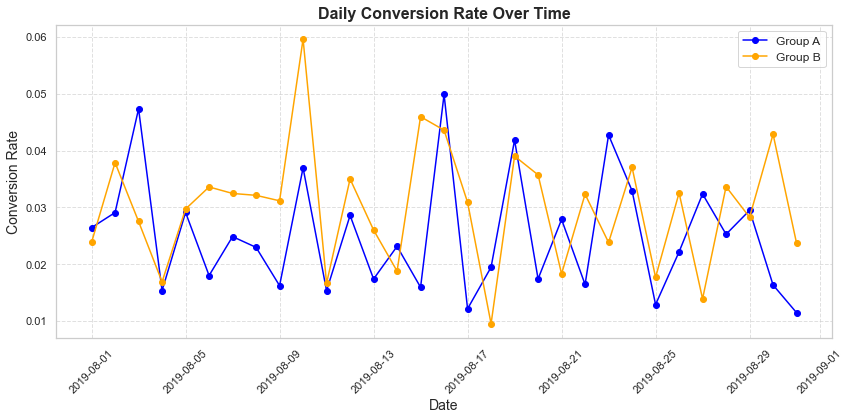

In [30]:
# Plot daily conversion rates over time
plt.figure(figsize=(12, 6))
plt.plot(group_a_cr['date'], group_a_cr['conversion'], label='Group A', color='blue', marker='o')
plt.plot(group_b_cr['date'], group_b_cr['conversion'], label='Group B', color='orange', marker='o')

plt.title('Daily Conversion Rate Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


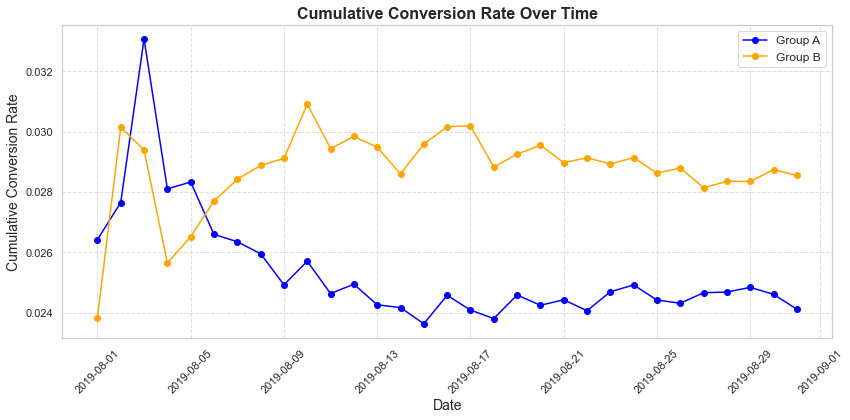

In [31]:
# Calculate cumulative sums
group_a_cr['cum_visitors'] = group_a_cr['visitors'].cumsum()
group_a_cr['cum_customers'] = group_a_cr['customers_count'].cumsum()
group_a_cr['cum_conversion'] = group_a_cr['cum_customers'] / group_a_cr['cum_visitors']

group_b_cr['cum_visitors'] = group_b_cr['visitors'].cumsum()
group_b_cr['cum_customers'] = group_b_cr['customers_count'].cumsum()
group_b_cr['cum_conversion'] = group_b_cr['cum_customers'] / group_b_cr['cum_visitors']

# Plot cumulative conversion over time
plt.figure(figsize=(12, 6))
plt.plot(group_a_cr['date'], group_a_cr['cum_conversion'], label='Group A', color='blue', marker='o')
plt.plot(group_b_cr['date'], group_b_cr['cum_conversion'], label='Group B', color='orange', marker='o')

plt.title('Cumulative Conversion Rate Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Conversion Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
from scipy.stats import chi2_contingency

# Prepare data for test
# Summing by group
sum_a_visitors = group_a_cr['visitors'].sum()
sum_a_customers = group_a_cr['customers_count'].sum()

sum_b_visitors = group_b_cr['visitors'].sum()
sum_b_customers = group_b_cr['customers_count'].sum()

# Conversion rates
conv_a = sum_a_customers / sum_a_visitors
conv_b = sum_b_customers / sum_b_visitors

# Contingency table
contingency_table = np.array([
    [sum_a_customers, sum_a_visitors - sum_a_customers],
    [sum_b_customers, sum_b_visitors - sum_b_customers]
])

# Chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table, correction=False)

print("p-value:", p_value)
print(f"\nConversion rate A: {conv_a:.3%}")
print(f"Conversion rate B: {conv_b:.3%}")

# Interpretation and choosing the winner
alpha = 0.05

if p_value < alpha:
    print("\nThe null hypothesis (no difference in conversion rates) is rejected.")
    print("There is a significant difference in conversion rates between the control and test groups.")
    if conv_b > conv_a:
        print("Variant B performs significantly better.")
    else:
        print("Variant A performs significantly better.")
else:
    print("\nThe null hypothesis (no difference in conversion rates) cannot be rejected.")
    print("There is no significant difference in conversion rates between the control and test groups.")


p-value: 0.007384482548540489

Conversion rate A: 2.412%
Conversion rate B: 2.855%

The null hypothesis (no difference in conversion rates) is rejected.
There is a significant difference in conversion rates between the control and test groups.
Variant B performs significantly better.


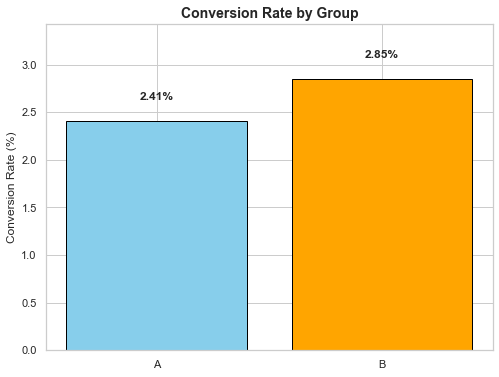

In [33]:
# Conversion rates in percentage
conv_a_percent = conv_a * 100
conv_b_percent = conv_b * 100

# Data for the plot
groups = ['A', 'B']
conversion_rates = [conv_a_percent, conv_b_percent]

# Visualization
plt.figure(figsize=(8, 6))
bars = plt.bar(groups, conversion_rates, color=['skyblue', 'orange'], edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Conversion Rate by Group', fontsize=14, fontweight='bold')
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.ylim(0, max(conversion_rates) * 1.2)
plt.show()


#### Metric 2: Average Order Value (AOV)

In [34]:
# Filter data by groups
group_a_aov = merged_df[merged_df['group'] == 'A'].copy()
group_b_aov = merged_df[merged_df['group'] == 'B'].copy()

# Calculate average revenue per order
group_a_aov['avg_revenue_per_order'] = group_a_aov['revenue_sum'] / group_a_aov['orders_count']
group_b_aov['avg_revenue_per_order'] = group_b_aov['revenue_sum'] / group_b_aov['orders_count']


In [35]:
# Calculate and print the average order value (AOV) for Group A
group_a_aov_value = round(group_a_aov['revenue_sum'].sum() / group_a_aov['orders_count'].sum(), 2)
print("Average Order Value (AOV) for Group A:", group_a_aov_value)

# Calculate and print the average order value (AOV) for Group B
group_b_aov_value = round(group_b_aov['revenue_sum'].sum() / group_b_aov['orders_count'].sum(), 2)
print("Average Order Value (AOV) for Group B:", group_b_aov_value)


Average Order Value (AOV) for Group A: 6504.55
Average Order Value (AOV) for Group B: 6298.83


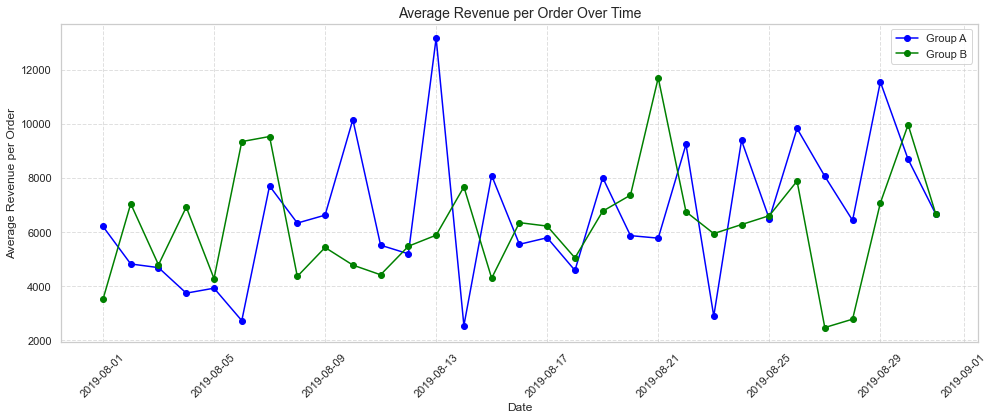

In [36]:
# Sort by date
group_a_aov = group_a_aov.sort_values('date')
group_b_aov = group_b_aov.sort_values('date')

# Plotting the graph
plt.figure(figsize=(14, 6))

plt.plot(group_a_aov['date'], group_a_aov['avg_revenue_per_order'], marker='o', label='Group A', color='blue')
plt.plot(group_b_aov['date'], group_b_aov['avg_revenue_per_order'], marker='o', label='Group B', color='green')

plt.title('Average Revenue per Order Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Revenue per Order', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


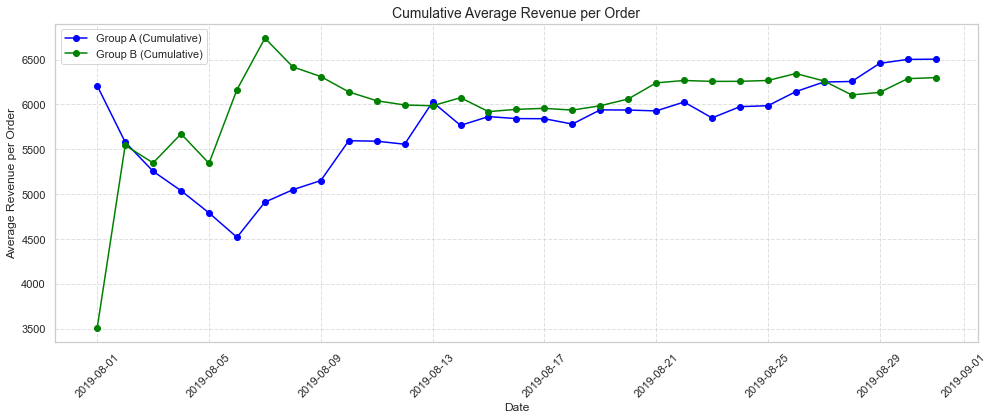

In [37]:
# Calculate cumulative sums
group_a_aov['cum_revenue'] = group_a_aov['revenue_sum'].cumsum()
group_a_aov['cum_orders'] = group_a_aov['orders_count'].cumsum()
group_a_aov['cum_avg_revenue_per_order'] = group_a_aov['cum_revenue'] / group_a_aov['cum_orders']

group_b_aov['cum_revenue'] = group_b_aov['revenue_sum'].cumsum()
group_b_aov['cum_orders'] = group_b_aov['orders_count'].cumsum()
group_b_aov['cum_avg_revenue_per_order'] = group_b_aov['cum_revenue'] / group_b_aov['cum_orders']

# Plotting the graph
plt.figure(figsize=(14, 6))

plt.plot(group_a_aov['date'], group_a_aov['cum_avg_revenue_per_order'], marker='o', label='Group A (Cumulative)', color='blue')
plt.plot(group_b_aov['date'], group_b_aov['cum_avg_revenue_per_order'], marker='o', label='Group B (Cumulative)', color='green')

plt.title('Cumulative Average Revenue per Order', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Revenue per Order', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Group A:
Normal distribution.

Group B:
Normal distribution.


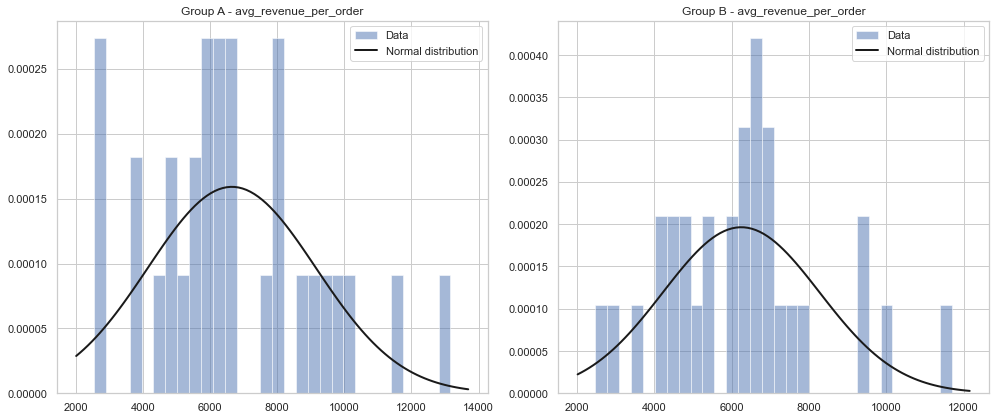

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ----------- Group A -----------
metric_data_a = group_a_aov['avg_revenue_per_order'].dropna()
stat_a, p_a = shapiro(metric_data_a)
alpha = 0.05

print("Group A:")
if p_a > alpha:
    print("Normal distribution.")
else:
    print("Not a normal distribution.")

ax = axes[0]
ax.hist(metric_data_a, bins=30, density=True, alpha=0.5, label='Data')
mu_a, std_a = norm.fit(metric_data_a)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_a, std_a)
ax.plot(x, p, 'k', linewidth=2, label='Normal distribution')
ax.set_title('Group A - avg_revenue_per_order')
ax.legend()

# ----------- Group B -----------
metric_data_b = group_b_aov['avg_revenue_per_order'].dropna()
stat_b, p_b = shapiro(metric_data_b)

print("\nGroup B:")
if p_b > alpha:
    print("Normal distribution.")
else:
    print("Not a normal distribution.")

ax = axes[1]
ax.hist(metric_data_b, bins=30, density=True, alpha=0.5, label='Data')
mu_b, std_b = norm.fit(metric_data_b)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_b, std_b)
ax.plot(x, p, 'k', linewidth=2, label='Normal distribution')
ax.set_title('Group B - avg_revenue_per_order')
ax.legend()

plt.tight_layout()
plt.show()


In [39]:
aov_a = group_a_aov['avg_revenue_per_order']
aov_b = group_b_aov['avg_revenue_per_order']

# Welch’s t-test (equal_var=False by default)
stat, p_value = ttest_ind(aov_a, aov_b, equal_var=False)

print(f"T-test statistic: {stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Statistically significant difference between groups (reject H0)")
else:
    print("No statistically significant difference between groups (fail to reject H0)")


T-test statistic: 0.691
P-value: 0.4923
No statistically significant difference between groups (fail to reject H0)


#### Metric 3: Average Revenue Per User (ARPU)

In [40]:
# Filter data by groups
group_a_arpu = merged_df[merged_df['group'] == 'A'].copy()
group_b_arpu = merged_df[merged_df['group'] == 'B'].copy()

# Calculate Average Revenue Per User (ARPU)
group_a_arpu['arpu'] = group_a_arpu['revenue_sum'] / group_a_arpu['visitors']
group_b_arpu['arpu'] = group_b_arpu['revenue_sum'] / group_b_arpu['visitors']


In [41]:
# Calculate and print the Average Revenue Per User (ARPU) for Group A
group_a_arpu_value = round(group_a_arpu['revenue_sum'].sum() / group_a_arpu['visitors'].sum(), 2)
print("ARPU for Group A:", group_a_arpu_value)

# Calculate and print the Average Revenue Per User (ARPU) for Group B
group_b_arpu_value = round(group_b_arpu['revenue_sum'].sum() / group_b_arpu['visitors'].sum(), 2)
print("ARPU for Group B:", group_b_arpu_value)


ARPU for Group A: 160.74
ARPU for Group B: 181.15


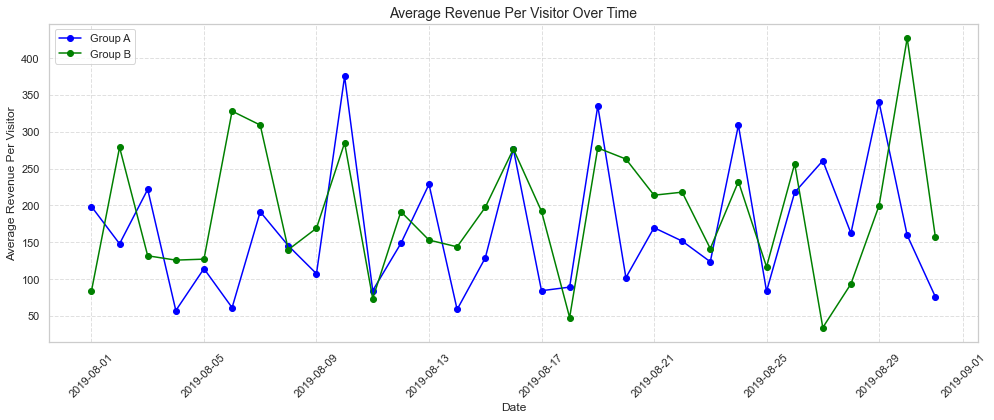

In [42]:
# Plotting ARPU over time for both groups
plt.figure(figsize=(14, 6))

plt.plot(group_a_arpu['date'], group_a_arpu['arpu'], marker='o', label='Group A', color='blue')
plt.plot(group_b_arpu['date'], group_b_arpu['arpu'], marker='o', label='Group B', color='green')

plt.title('Average Revenue Per Visitor Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Revenue Per Visitor', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


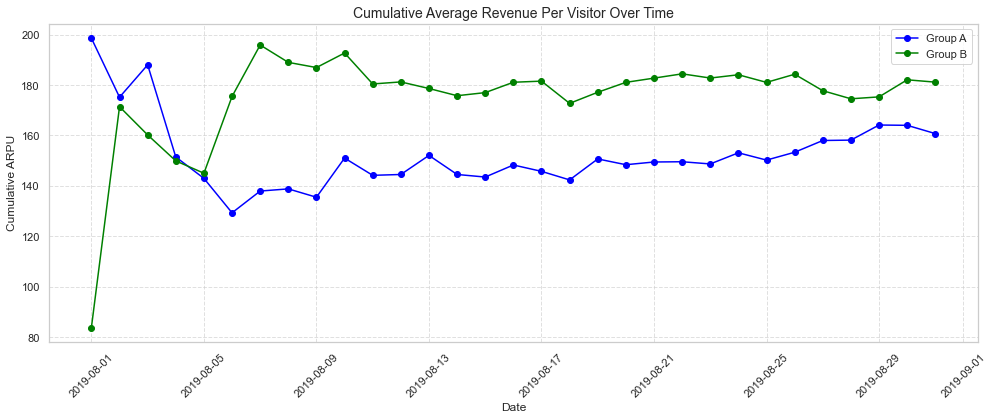

In [43]:
# Calculate cumulative sums by date
group_a_arpu['cum_revenue'] = group_a_arpu['revenue_sum'].cumsum()
group_a_arpu['cum_visitors'] = group_a_arpu['visitors'].cumsum()
group_a_arpu['cum_arpu'] = group_a_arpu['cum_revenue'] / group_a_arpu['cum_visitors']

group_b_arpu['cum_revenue'] = group_b_arpu['revenue_sum'].cumsum()
group_b_arpu['cum_visitors'] = group_b_arpu['visitors'].cumsum()
group_b_arpu['cum_arpu'] = group_b_arpu['cum_revenue'] / group_b_arpu['cum_visitors']

# Plot cumulative ARPU over time
plt.figure(figsize=(14, 6))

plt.plot(group_a_arpu['date'], group_a_arpu['cum_arpu'], marker='o', label='Group A', color='blue')
plt.plot(group_b_arpu['date'], group_b_arpu['cum_arpu'], marker='o', label='Group B', color='green')

plt.title('Cumulative Average Revenue Per Visitor Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative ARPU', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Group A:
Not a normal distribution.

Group B:
Normal distribution.


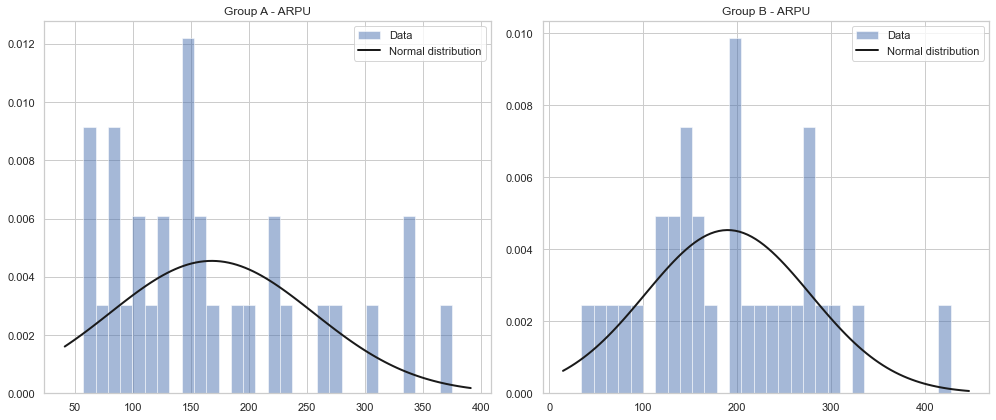

In [44]:
# Check if the distribution is normal
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

alpha = 0.05  # significance level for normality test

# ----------- Group A -----------
metric_data_a = group_a_arpu['arpu'].dropna()
stat_a, p_a = shapiro(metric_data_a)

print("Group A:")
if p_a > alpha:
    print("Normal distribution.")
else:
    print("Not a normal distribution.")

ax = axes[0]
ax.hist(metric_data_a, bins=30, density=True, alpha=0.5, label='Data')
mu_a, std_a = norm.fit(metric_data_a)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_a, std_a)
ax.plot(x, p, 'k', linewidth=2, label='Normal distribution')
ax.set_title('Group A - ARPU')
ax.legend()

# ----------- Group B -----------
metric_data_b = group_b_arpu['arpu'].dropna()
stat_b, p_b = shapiro(metric_data_b)

print("\nGroup B:")
if p_b > alpha:
    print("Normal distribution.")
else:
    print("Not a normal distribution.")

ax = axes[1]
ax.hist(metric_data_b, bins=30, density=True, alpha=0.5, label='Data')
mu_b, std_b = norm.fit(metric_data_b)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_b, std_b)
ax.plot(x, p, 'k', linewidth=2, label='Normal distribution')
ax.set_title('Group B - ARPU')
ax.legend()

plt.tight_layout()
plt.show()


In [45]:
# Mann-Whitney U test between ARPU of group A and group B
stat, p_value = mannwhitneyu(group_a_arpu['arpu'], group_b_arpu['arpu'], alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a statistically significant difference between groups (reject H0)")
else:
    print("No statistically significant difference between groups (fail to reject H0)")


Mann-Whitney U statistic: 404.000
P-value: 0.2846
No statistically significant difference between groups (fail to reject H0)


### Step 5. Conclusion & Recommendation

📊 **A/B Test Evaluation: Variant A vs Variant B**

**Test Metrics Summary**

**Conversion Rate (CR):**
- Variant A: 2.412%
- Variant B: 2.855%
- p-value: 0.0074 → **Statistically significant**
- Interpretation: Variant B has a significantly higher conversion rate.

**Average Order Value (AOV):**
- Group A: 6504.55  
- Group B: 6298.83  
- p-value: 0.4923 → **Not statistically significant**
- Interpretation: Slightly lower AOV in Variant B, but difference is not statistically significant.

**Average Revenue Per User (ARPU):**
- Group A: 160.74  
- Group B: 181.15  
- p-value: 0.2846 → **Not statistically significant**
- Interpretation: ARPU is higher in Variant B, though the difference is not statistically significant.

---

📌 **Conclusion**

- Variant B demonstrates a **statistically significant improvement in conversion rate** over Variant A.
- Although **AOV is slightly lower** in Variant B, the difference is not statistically significant.
- **ARPU is higher in Variant B**, indicating that the increase in conversions may be driving more total revenue per user, even though the difference is not statistically significant.
- Overall, Variant B improves user acquisition efficiency without sacrificing revenue quality.

---

🚀 **Recommendations for Growth Team**

- ✅ **Adopt Variant B** as the new default, given its proven impact on conversion rate and the trend toward higher ARPU.
- 📊 **Monitor AOV and ARPU post-rollout**, especially since Variant B users place more orders but spend slightly less per order — focus on net revenue impact.
- 📈 **Explore strategies to lift AOV in Variant B**, such as:
  - Intelligent product bundling
  - Targeted promotions (e.g., "free shipping over X")
  - Personalized upselling techniques
- 🧪 **Consider running a follow-up experiment** focused specifically on ARPU optimization — since Variant B shows potential, additional iterations may solidify revenue gains.
- 📣 **Communicate the success of Variant B** to product and marketing stakeholders as a validated growth lever.
